In [3]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
current_dir = os.getcwd()
current_dir

'/Users/benho/Documents/ComputerVision/CombineImages'

In [17]:
images = []
for file in glob.glob(current_dir + "/images/*"):
    print(file)
    img = cv2.imread(file)
    print(img.shape)
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_new = img_color[:2024, :3430, :]
    print(img_new.shape)
    images.append(img_new)

/Users/benho/Documents/ComputerVision/CombineImages/images/4.png
(2024, 3431, 3)
(2024, 3430, 3)
/Users/benho/Documents/ComputerVision/CombineImages/images/2.png
(2025, 3431, 3)
(2024, 3430, 3)
/Users/benho/Documents/ComputerVision/CombineImages/images/3.png
(2023, 3431, 3)
(2023, 3430, 3)
/Users/benho/Documents/ComputerVision/CombineImages/images/1.png
(2026, 3430, 3)
(2024, 3430, 3)


In [19]:
def alignImages(im1, im2):
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    # Detect ORB features and compute descriptors
    orb = cv2.ORB_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    
    # Match features
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    # Remove poor matches
    numGoodMatches = int(len(matches) * 0.15)
    matches = matches[:numGoodMatches]
    
    # Draw matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    
    # Extract location of matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    
    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    
    return im1Reg, h

In [25]:
aligned_images = []
aligned_images.append(images[0])
for img in images[1:]:
    imReg, _ = alignImages(img, images[0])
    print(imReg.shape)
    aligned_images.append(imReg)

(2024, 3430, 3)
(2024, 3430, 3)
(2024, 3430, 3)


In [43]:
b = []
g = []
r = []
for img in aligned_images:
    b.append(np.expand_dims(img[:, :, 2], 2))
    g.append(np.expand_dims(img[:, :, 1], 2))
    r.append(np.expand_dims(img[:, :, 0], 2))
blue = np.concatenate(b, axis=2)
green = np.concatenate(g, axis=2)
red = np.concatenate(r, axis=2)

In [57]:
def create_image(color):
    new_array = np.zeros((2024, 3430))

    for i in range(2024):
        for j in range(3430):
            val = min(color[i,j,:])
            new_array[i,j] = val
    return new_array

In [58]:
new_blue = create_image(blue)
new_red = create_image(red)
new_green = create_image(green)

In [64]:
new_image = np.zeros((2024, 3430, 3), dtype=np.uint8)
new_image[:, :, 0] = new_red
new_image[:, :, 1] = new_green
new_image[:, :, 2] = new_blue

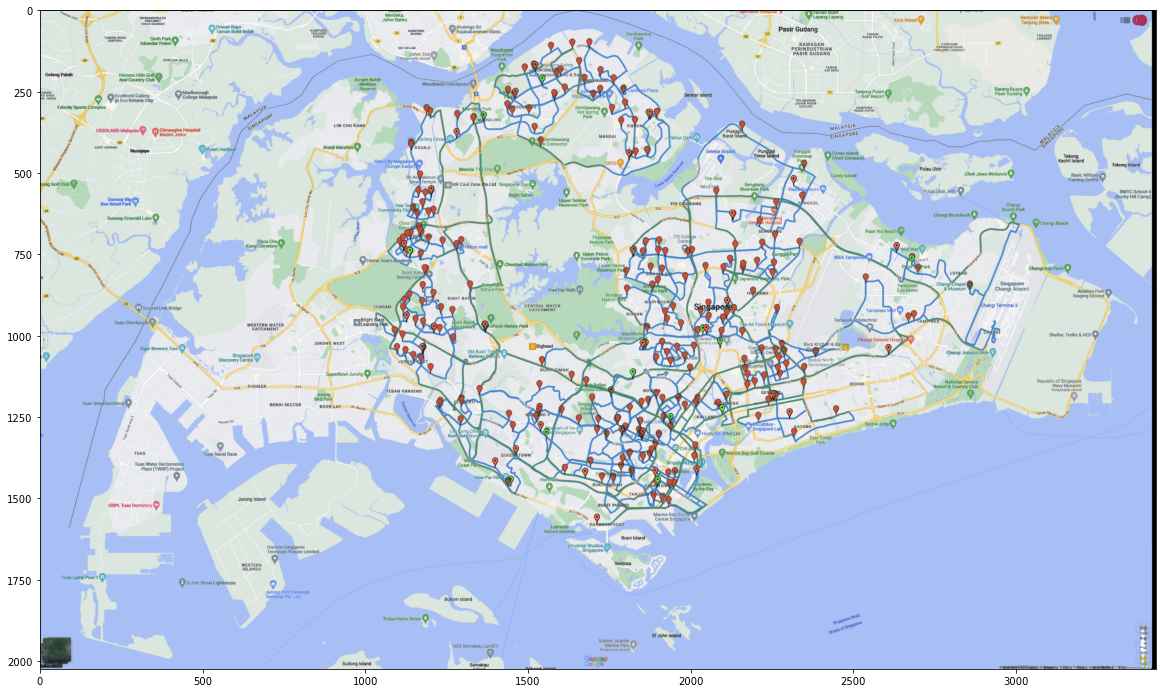

In [66]:
figure = plt.figure(figsize=(20, 30))
# plt.imshow(blue)
# plt.imshow(green)
# plt.imshow(red)
plt.imshow(new_image)
plt.savefig("combined_image.jpg")